In [ ]:

import os
import cv2
import numpy as np
from skimage import exposure
import pandas as pd
import ast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from skimage.segmentation import chan_vese
from sklearn.metrics import jaccard_score


# 1: Data Preprocessing

In [ ]:
imagedb = pd.read_csv(os.path.join("data/train",'annota.csv'),index_col= False)
imgs = []
trgts = []

for idx in range(len(imagedb)):
    image_name = imagedb[imagedb["id"] == idx].to_numpy()[0][1]
    label = imagedb[imagedb["id"] == idx].to_numpy()[0][3]
    bbox = imagedb[imagedb["id"] == idx].to_numpy()[0][2]
    # convert string to a list of mixed types (int and float)
    bbox_list = ast.literal_eval(bbox)

    # convert all elements to integers (rounding the float values)
    bbox_int_list = [float(round(num)) for num in bbox_list]
    imgs.append(image_name)
    trgts.append({"labels" : label, "boxes" : bbox_int_list})

In [ ]:
trgts[0]

{'labels': 1, 'boxes': [314.0, 239.0, 145.0, 401.0]}

In [ ]:


class MRIDataset(Dataset):
    def __init__(self, image_folder, images , targets ,transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.images = images
        self.target = targets


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_folder, self.images[idx]), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32)  # Convert image to float32

        if self.transform:
            image = self.transform(image)
        labels_tensor = torch.tensor([self.target[idx]['labels']])
        a , b, c, d = self.target[idx]['boxes']
        if a == c:
            c= c+1
        if b == d:
            d = d +1
        if a < c and b < d:
            bb = [a, b, c, d]
        elif a < c and d < b:
            bb = [a, d, c, b]
        elif c < a and b < d:
            bb = [c, b, a, d]
        else:
            bb=[c, d, a, b]
        boxes_tensor = torch.tensor([bb])


        return image, {"labels" : labels_tensor, "boxes" : boxes_tensor}

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = MRIDataset(image_folder='data/train', images= imgs, targets= trgts,transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)





# 3 : Faster R-CNN for Localization

In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# model initilization
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)


model.to(device)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

# lists for losses and accuracy
epoch_losses = []
epoch_accuracies = []

for epoch in range(100):
    total_loss = 0
    num_batches = 0
    all_preds = []
    all_targets = []

    for images, targets in dataloader:
        model.train()
        
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        num_batches += 1

        
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            for i in range(len(outputs)):
                all_preds.append(outputs[i]['boxes'].cpu())
                all_targets.append(targets[i]['boxes'].cpu())

    
    avg_loss = total_loss / num_batches
    epoch_losses.append(avg_loss)

    # IoU base accuracy calculation
    iou_threshold = 0.01
    num_correct = 0
    num_samples = 0
    for preds, target_boxes in zip(all_preds, all_targets):
        for pred_box in preds:
            ious = torchvision.ops.box_iou(pred_box.unsqueeze(0), target_boxes)
            if (ious >= iou_threshold).any():
                num_correct += 1
        num_samples += 1#len(target_boxes)

    accuracy = num_correct / num_samples if num_samples > 0 else 0
    epoch_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


print("Losses for each epoch: ", epoch_losses)
print("Accuracies for each epoch: ", epoch_accuracies)

In [ ]:

plt.figure(figsize=(12, 6))

# Plot: Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epoch_numbers, loss, marker='o', color='b', label='Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss', rotation=90, labelpad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.legend()
plt.grid(True)




In [ ]:
img_path = 'data/test/1399_jpg.rf.f181f781289594b01f09c963eec9064e.jpg' 

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = image / 255.0
reshaped_image = image[np.newaxis, :, :]
tensor_img = torch.tensor(reshaped_image, dtype=torch.float32).to(device)
output = model([tensor_img])


In [ ]:
output

[{'boxes': tensor([[202.2045, 254.5716, 305.5206, 359.2991],
          [229.1791, 265.4216, 329.6694, 378.0959],
          [218.3996, 279.6322, 301.3525, 337.7260],
          [222.8978, 232.8377, 332.1390, 342.8056],
          [203.9719, 253.0887, 420.4486, 377.6304],
          [221.9796, 263.0989, 286.7166, 397.3443],
          [238.3593, 286.9632, 314.8545, 353.8142],
          [203.0825, 268.6080, 301.6605, 384.2378],
          [220.4089, 210.2777, 333.8502, 434.4609],
          [193.4177, 228.5096, 301.3665, 351.1874],
          [152.3429, 280.3590, 269.4759, 352.8548],
          [232.0943, 248.3060, 281.8532, 346.6659],
          [ 61.8822, 216.0330, 286.7492, 352.0929],
          [216.4929, 287.9322, 300.3192, 343.3179],
          [148.0135, 275.5817, 263.0855, 354.1679],
          [ 61.2704, 212.5011, 284.8200, 352.5204],
          [224.2467, 248.3125, 344.9626, 364.8936],
          [ 66.2851, 156.6094, 188.1120, 250.8079],
          [ 88.3258, 170.4649, 165.6590, 239.3947],
   

In [ ]:
output_score = output[0]

# to get the index of the bounding box with the highest score
max_score_index = torch.argmax(output_score['scores']).item()

highest_score_bbox = output_score['boxes'][max_score_index]
highest_score_label = output_score['labels'][max_score_index]


print(f"Highest score bounding box: {highest_score_bbox}")
print(f"Corresponding label: {highest_score_label}")

Highest score bounding box: tensor([202.2045, 254.5716, 305.5206, 359.2991], device='cuda:0',
       grad_fn=<SelectBackward0>)
Corresponding label: 2


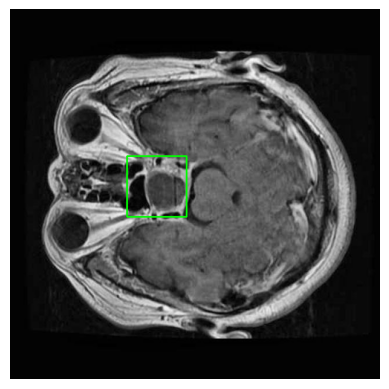

In [ ]:
output_scor = output[0]
image = image * 255.0
image = image.astype(np.uint8)


max_score_index = torch.argmax(output_scor['scores']).item()

# bounding box coordinates
highest_score_bbox = output_scor['boxes'][max_score_index].detach().cpu().numpy()

# coordinates converted to integers
x1, y1, x2, y2 = map(int, highest_score_bbox)
color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# the image converted to RGB 
image_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

# draw the bounding box on the image
cv2.rectangle(image_rgb, (x1,y1), (x2,y2), (0, 255, 0), 2)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

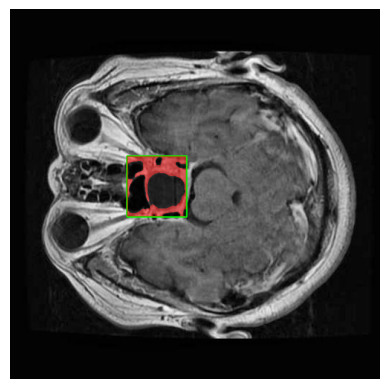

In [ ]:
roi = image_rgb[y1:y2, x1:x2]

# region of interest (ROI) converted to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# apply the Chan-Vese segmentation algorithm
cv_result = chan_vese(roi_gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)
segmented_mask = cv_result[0]

# inverted mask
inverted_mask = ~segmented_mask

# inverted mask to 3D image with same shape
segmented_image = np.zeros_like(roi)
segmented_image[inverted_mask] = [255, 0, 0]  # red color for the background region

# overlay the segemented mask on the image 
overlay = cv2.addWeighted(roi, 0.5, segmented_image, 0.5, 0)
image_rgb[y1:y2, x1:x2] = overlay

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
segmented_image

(array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 array([[ 0.00717884,  0.01271998,  0.01347814, ..., -0.02552251,
         -0.02559303, -0.02403628],
        [ 0.00724433,  0.01312757,  0.01433268, ..., -0.03859924,
         -0.05786947, -0.07243101],
        [ 0.00720376,  0.01287343,  0.01552945, ..., -0.0448975 ,
         -0.07149961, -0.08575576],
        ...,
        [-0.01055612, -0.03415536, -0.04430442, ...,  0.24351265,
          0.29226764,  0.31819594],
        [-0.01060455, -0.05556835, -0.07242012, ...,  0.29215562,
          0.3418204 ,  0.36690771],
        [-0.01027718, -0.07216913, -0.08781124, ...,  0.31786214,
          0.36677859,  0.38573854]]),
 [845.3843613827